# Task 8.2 Open QASM3

**Overview:** This notebook covers how to convert between QASM3 and qiskit, it covers different import and export options and errors that might happpen during conversion.

In [1]:
# Setup: Import necessary libraries
from qiskit import QuantumCircuit
from qiskit.qasm3 import dump, dumps,load,loads,loads_experimental
from qiskit.qasm3 import Exporter,QASM3ExporterError,QASM3ImporterError
from qiskit.providers.fake_provider import GenericBackendV2

print("Libraries imported successfully.")

Libraries imported successfully.


## Objective : Interpret QASM3 language and inter-convert between qiskit and QASM3

Qiskit provides tools to export quantum circuits to QASM3 format and import QASM3 files back into Qiskit circuits.


### Exporting to QASM 3

#### Export Methods

* **`dump()`**: Export circuit to a file
* **`dumps()`**: Export circuit to an Open QASM3 string

In [2]:
# Example export to file and string
# A file will be created in the current directory named 'sample_qasm.txt'

# Create a simple circuit
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

# Export to string
qasm_str = dumps(qc)
print("QASM3 String:\n")
print(qasm_str)

# Export to file
with open("sample_qasm.txt", "w") as f:
    dump(qc, f)

QASM3 String:

OPENQASM 3.0;
include "stdgates.inc";
bit[2] c;
qubit[2] q;
h q[0];
cx q[0], q[1];
c[0] = measure q[0];
c[1] = measure q[1];



#### Exporter Class

It can be used to customize the export process.

**Parameters**:
* **`includes`**: List of files to include (default: `["stdgates.inc"]`)
* **`basis_gates`**: Limit to specific gate set for hardware compatibility
* **`disable_constants`**: Disable constant folding optimizations
* **`alias_classical_registers`**: Use aliases for classical registers
* **`allow_aliasing`**: Allow use of `let` statements for qubit aliasing
* **`indent`**: String used for indentation (default: "  ")
* **`experimental`**: Enable experimental features
* **`annotation_handlers`**: Custom handlers for circuit annotations

In [3]:
# Example with Exporeter class

qc = QuantumCircuit(3)
qc.h(0)
qc.rx(1.57, 1)  # π/2 rotation

exporter = Exporter(
    # Don't include stdgates.inc
    includes=[],
    # Limit to specific gates
    basis_gates=["h", "rx"],
    # 4-space indentation
    indent="    ",
    allow_aliasing=True
)

# Export with custom exporter
qasm_str = exporter.dumps(qc)
print(qasm_str)


OPENQASM 3.0;
qubit[3] q;
h q[0];
rx(1.57) q[1];



#### QASM3ExporterError

The exporter raises `QASM3ExporterError` when it encounters unsupported features.

In [4]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
# invalid use to test error handling
backend = GenericBackendV2(2)
exporter = Exporter(basis_gates=backend.operation_names)

try:
    qasm_str = exporter.dumps(qc)
    print(f"Export successful: {qasm_str}")
except QASM3ExporterError as e:
    print(f"Export failed: {e}")

Export failed: "Cannot use 'reset' as a basis gate for the reason in the prior exception. Consider renaming the gate if needed, or omitting this basis gate if not."


#### Experimental Features

Access experimental features through `ExperimentalFeatures`.

### Importing from QASM 3

#### Import Methods

* **`load()`**: Import circuit from a file
* **`loads()`**: Import circuit from a string


**Note:**
package qiskit_qasm3_import must be installed. This can be done using
```pip install qiskit_qasm3_import```

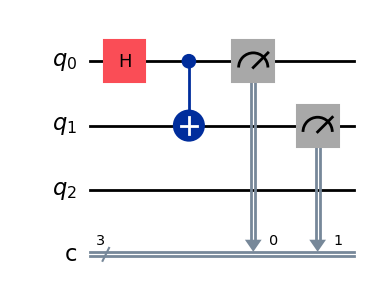

In [5]:
# Example import from QASM3 string
qasm_code = """
OPENQASM 3.0;
include "stdgates.inc";

qubit[3] q;
bit[3] c;

h q[0];
cx q[0], q[1];

c[0] = measure q[0];
c[1] = measure q[1];
"""

# Import from string
circuit = loads(qasm_code)

circuit.draw('mpl')

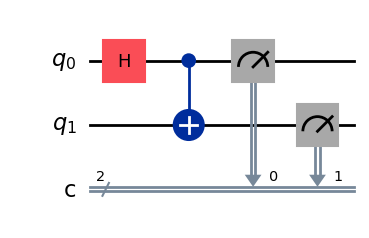

In [6]:
# Example Import from file
circuit = load("sample_qasm.txt")
circuit.draw('mpl')


#### QASM3ImporterError

The importer raises `QASM3ImoporterError` when it encounters unsupported features.

In [7]:
# Invalid QASM3 code
invalid_qasm = """
OPENQASM 3.0;
include "stdgates.inc";
qubit q;  
rh q; // unknown gate
"""

try:
    circuit = loads(invalid_qasm)
except QASM3ImporterError as e:
    print(f"Import failed: {e}")

Import failed: "5,0: gate 'rh' is not defined."


#### Experimental Import Interface

Experimental Rust-based importer that is much faster.

##### Import Methods

* **`load_experimental()`**: Import circuit from a file
* **`loads_experimental()`**: Import circuit from a string

c:\QC\venvs\test\.venv\Lib\site-packages\qiskit\qasm3\__init__.py:442: ExperimentalWarning: This is an experimental native version of the OpenQASM 3 importer. Beware that its interface might change, and it might be missing features.
  warnings.warn(


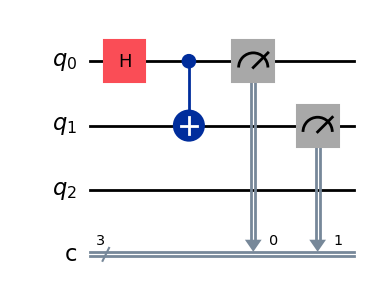

In [8]:
# Example import from QASM3 string
qasm_code = """
OPENQASM 3.0;
include "stdgates.inc";

qubit[3] q;
bit[3] c;

h q[0];
cx q[0], q[1];

c[0] = measure q[0];
c[1] = measure q[1];
"""

# Import from string
circuit = loads_experimental(qasm_code)

circuit.draw('mpl')

---

# Task 8.3 QASM3 with Qiskit SDK

## Objective : Interoperate different versions of OpenQASM with Qiskit

### Import QASM3 file into qiskit


Qiskit can import OpenQASM 3.0 programs using the `loads()` function for strings or `load()` for files.

Importing to Qiskit supports the following features

- Basic quantum gates and circuits
- Classical control flow (if/while)
- Custom gate definitions
- Parameterized circuits
- Measurement and reset operations

Check https://quantum.cloud.ibm.com/docs/en/guides/qasm-feature-table for a more detailed view on supported features.

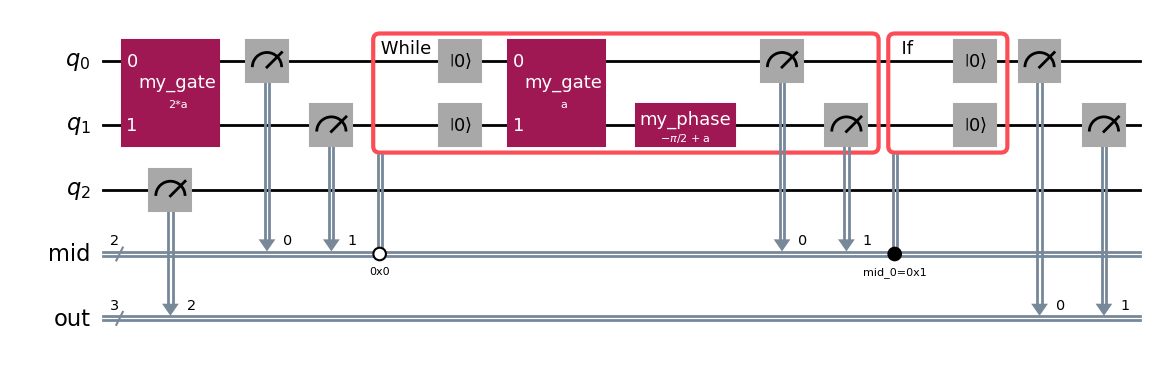

In [9]:
# Example of importing a complex OpenQASM 3.0 program into Qiskit
program = """
    OPENQASM 3.0;
    include "stdgates.inc";
 
    input float[64] a;
    qubit[3] q;
    bit[2] mid;
    bit[3] out;
 
    let aliased = q[0:1];
 
    gate my_gate(a) c, t {
      gphase(a / 2);
      ry(a) c;
      cx c, t;
    }
    gate my_phase(a) c {
      ctrl @ inv @ gphase(a) c;
    }
 
    my_gate(a * 2) aliased[0], q[{1, 2}][0];
    measure q[0] -> mid[0];
    measure q[1] -> mid[1];
 
    while (mid == "00") {
      reset q[0];
      reset q[1];
      my_gate(a) q[0], q[1];
      my_phase(a - pi/2) q[1];
      mid[0] = measure q[0];
      mid[1] = measure q[1];
    }
 
    if (mid[0]) {
      let inner_alias = q[{0, 1}];
      reset inner_alias;
    }
 
    out = measure q;
"""
circuit = loads(program)
circuit.draw("mpl")

### Export to QASM3


Qiskit can export circuits to OpenQASM 3.0 format using `dumps()` for strings or `dump()` for files.

Exporintg to QASM3 supports the following features:

- Converts Qiskit circuits to standard QASM3 format
- Supports parameterized circuits
- Can include custom gate decompositions
- Compatible with IBM Quantum Runtime API

In [10]:
# Exporting a Qiskit QuantumCircuit to a String in OpenQASM 3.0 format
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
dumps(qc)

'OPENQASM 3.0;\ninclude "stdgates.inc";\nbit[2] meas;\nqubit[2] q;\nh q[0];\ncx q[0], q[1];\nbarrier q[0], q[1];\nmeas[0] = measure q[0];\nmeas[1] = measure q[1];\n'

In [11]:
# Exporting a Qiskit QuantumCircuit to a File in OpenQASM 3.0 format
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
f = open("sample_qasm.txt", "w")
dump(qc, f)
f.close()

---
## Summary
---

In this notebook, we covered:

## Interoperate between QASM and QISKIT:

1. **Export from qiskit to QASM**  can be done to a file or a string, and customaization can be preformed using `Exporter` class.
2. **Import from QASM to qiskit** can be done from a file or a string.
3. **experimental importer** uses a rust based class that is much faster.
4. **Import/Export from QASM to Qiskt** supports specific features.


---

## Practice Questions

**1) When the Exporter class is used to customize QASM3 export, which parameter allows you to restrict the exported gates to a specific set for hardware compatibility?**

A) allow_aliasing

B) basis_gates

C) includes

D) disable_constants


***Answer:***
<Details>
B) basis_gates parameter limits the gate set to use on a specific target hardware
<br/>
</Details>

---

**2) What will be printed when the following code is executed??**

```
from qiskit.qasm3 import loads

qasm_string = """

OPENQASM 3.0;
include "stdgates.inc";

qubit[3] q;
bit[3] c;

h q[0];
cx q[0], q[1];

c[0] = measure q0;
c[1] = measure q1;
"""

try:
    circuit = loads(qasm_string)
    print("Circuit loaded successfully")
except Exception as e:
    print(f"Error: {type(e).__name__}")
```

A) Circuit loaded successfully

B) Error: QASM3ExporterError

C) Error: QASM3ImportError

D) Error: QASM3ImporterError


***Answer:***
<Details>
D) QASM3ImporterError will be thrown as measurment is done on non existant qubits q0 and q1
<br/>
</Details>

---

**3) For the code below, Which statement is TRUE?**

```
from qiskit.qasm3 import loads

qasm = """
OPENQASM 3.0;
include "stdgates.inc";

qubit q;
bit c;

h q;

c = measure q;

if (c) {
  x q;
}
"""
qc = loads(qasm)
print(qc)
```

A) The circuit is imported as a QuantumCircuit and printed

B) The classical if is ignored as it is not supported

C) Import fails and throws QASM3ImoporterError

D) The circuit is imported and executed

***Answer:***
<Details>
A) The circtit is imported and printed , as classical if, basic gates and measurements are supported.
<br/>
</Details>

---

**4) What is the main difference between dump() and dumps()?**

A) dump() returns a string, dumps() saves to a file object

B) dump() is for QASM2, dumps() is for QASM3

C) dump() saves to a file object, dumps() returns a string

D) dumps() supports sepecial features, dump() does not

***Answer:***
<Details>

C) dump() converts the circuit to a QASM script and saves it as a file on the disk, dumps() converts the circuit to a QASM script and it returns it as a string
<br/>
</Details>

---